### Kmeans and Kmeans++
#### Kyrill Rekun

In [776]:
%run kmeans

Before walking through what I did for the kmeans project, I wanted to talk about some of the challenges I encountered. I first did kmeans and kmeans++ using loops which worked fine smaller datasets, but once I got to image decompression I quickly realized how foolish my code was. Compressing an image for half an hour was not fun at all! O(n) matters!!

This got me thinking back to linear algebra bootcamp and how we did SVD for image compression and thanks to some timely advice from Max, I decided to rewrite my initial code using Matrix properties to get rid of all the ugly nested for loops. 

Below are comparisons of the kmeans code to highlight the differences in efficiency.

In [733]:
def kmeans_plus_plus_loop(X, k):
    centroids = []
    centroids.append(X[np.random.choice(X.shape[0], 1, replace=False)])
    for cent in range(k-1):
        dist = np.zeros(shape=[X.shape[0], cent+1])
        for i in range(X.shape[0]):
            for j in range(len(centroids)):
                dist[i][j] = get_dist(X[i], centroids[j])
        min_dist = np.amin(dist, axis=1)
        index = np.unravel_index(np.argmax(min_dist, axis=None), dist.shape)[0]
        centroids.append(X[index])
    return centroids

This implementation has to iterate to create all remaining centroids by touching every row for every existing centroid. (That was painful to write) Just taking the loop structure and ignoring runtime for np and lookup/write operations we are already looking at an O(n) of $k^2*n$ and that is just to create initial centroids! While this worked fine for many smaller datasets, as soon as I tried image compression with $k>8$ runtime would balloon. Another thing that I was doing wrong was that I did not keep track of indexes of the centroids to save some redundant computations. 

In [771]:
def kmeans_plus_plus(X, k):
    centroid_index = np.random.choice(X.shape[0], 1, replace=False)
    centroids = X[centroid_index]
    for i in range(k-1):
        dist = cdist(X, centroids, 'euclidean')
        min_dist = np.amin(dist, axis=1)
        min_dist[centroid_index] = -1
        max_dist = np.argmax(min_dist)

        centroids = np.append(centroids, [X[max_dist]], axis=0)
        centroid_index = np.append(centroid_index, [max_dist], axis=0)

    return centroids

(Credit to Max for showing me the scipy cdist function!)

This is the matrix way of doing kmeans++ implementation. Right away you can see that there are no nested for loops. CDIST() allows us to apply euclidean distance to the entire X matrix for all centroids without having to manually loop through the matrix. Assuming that CDIST and other np functions run in constant time $p$, we get an O(n) of just $p*(k-1)$ which is much much faster than my initial naive loop version!

This is just time saved on generating initial clusters. Now consider that similar code was used for the while loops for the remainder of kmeans implementation. Iterating over every row of X for every centroid makes logical sense, but is definitely a very poor implementation choice. Now the matrix implentation of kmeans takes less than 30seconds compared to loop variant taking 15min+. This goes to show the importance of taking into consideration runtime and O(n) to correctly choose an algorithm before implementing it. Otherwise, you will be like me and finish a project only to find what you did is highly inefficient and not something to be proud of.

In [781]:
grades = [92.65, 93.87, 74.06, 86.94, 92.26, 94.46, 92.94, 80.65,
          92.86, 85.94, 91.79, 95.23, 85.37, 87.85, 87.71, 93.03]
k = 3
grades = np.array(grades).reshape(-1, 1)

centroids, clusters = kmeans(grades, k)
print('Centroids:', centroids)
print('Clusters:', clusters)
for i in range(k):
    print('Cluster ' + str(i+1) + ': ', grades[clusters[i]].reshape(1, -1))

Centroids: [[77.355     ]
 [86.762     ]
 [93.23222222]]
Clusters: [array([2, 7]), array([ 3,  9, 12, 13, 14]), array([ 0,  1,  4,  5,  6,  8, 10, 11, 15])]
Cluster 1:  [[74.06 80.65]]
Cluster 2:  [[86.94 85.94 85.37 87.85 87.71]]
Cluster 3:  [[92.65 93.87 92.26 94.46 92.94 92.86 91.79 95.23 93.03]]


In [792]:
centroids, clusters = kmeans(grades, k)
print('Centroids:', centroids)
print('Clusters:', clusters)
for i in range(k):
    print('Cluster ' + str(i+1) + ': ', grades[clusters[i]].reshape(1, -1))

Centroids: [[84.07428571]
 [92.58833333]
 [94.52      ]]
Clusters: [array([ 2,  3,  7,  9, 12, 13, 14]), array([ 0,  4,  6,  8, 10, 15]), array([ 1,  5, 11])]
Cluster 1:  [[74.06 86.94 80.65 85.94 85.37 87.85 87.71]]
Cluster 2:  [[92.65 92.26 92.94 92.86 91.79 93.03]]
Cluster 3:  [[93.87 94.46 95.23]]


I was puzzled that when doing random initialization of centroids, if your centroids were too similar weird combinations of clusters could happen. For example, take the two test outputs above. Exact same code, but because the centroid initialization did not pick up any lower bound grades, it fixed the centroids in a way that result in grades of 90+ being split into two clusters. However, if the randomn initial centroids happened to pull out 74 or 80, we would get more reasonable and expected results.

This issue of randomness is solved by kmeans++. We can see below that it correctly splits grades into 70/80/90 clusters!

In [773]:
grades = [92.65, 93.87, 74.06, 86.94, 92.26, 94.46, 92.94, 80.65,
          92.86, 85.94, 91.79, 95.23, 85.37, 87.85, 87.71, 93.03]
k = 3
grades = np.array(grades).reshape(-1, 1)

centroids, clusters = kmeans(grades, k, 'kmeans++')
print('Centroids:', centroids)
print('Clusters:', clusters)
for i in range(k):
    print('Cluster ' + str(i+1) + ': ', grades[clusters[i]].reshape(1, -1))

Centroids: [[85.74333333]
 [74.06      ]
 [93.23222222]]
Clusters: [array([ 3,  7,  9, 12, 13, 14]), array([2]), array([ 0,  1,  4,  5,  6,  8, 10, 11, 15])]
Cluster 1:  [[86.94 80.65 85.94 85.37 87.85 87.71]]
Cluster 2:  [[74.06]]
Cluster 3:  [[92.65 93.87 92.26 94.46 92.94 92.86 91.79 95.23 93.03]]


Below is another kmeans test that I did on basic (x,y) data to see if my kmeans works as it is suppose to for multidimensional rows. It also visually highlights how clustering is suppose to work.

    
###### TEST SOURCE: https://mubaris.com/posts/kmeans-clustering/

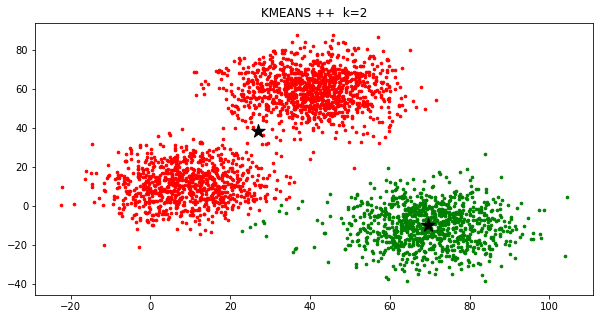

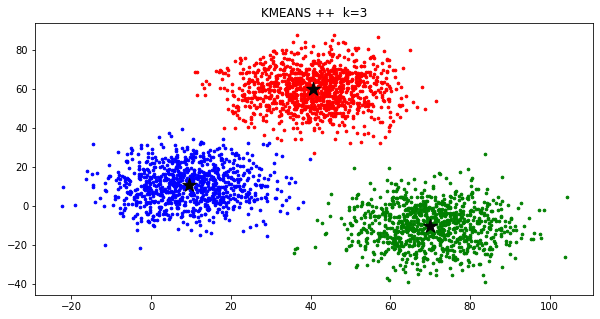

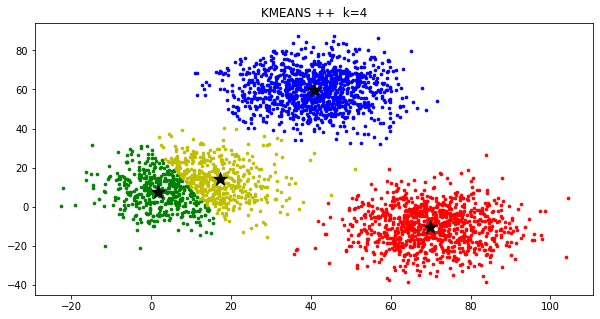

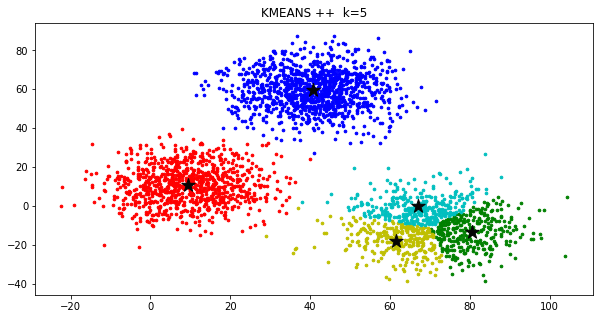

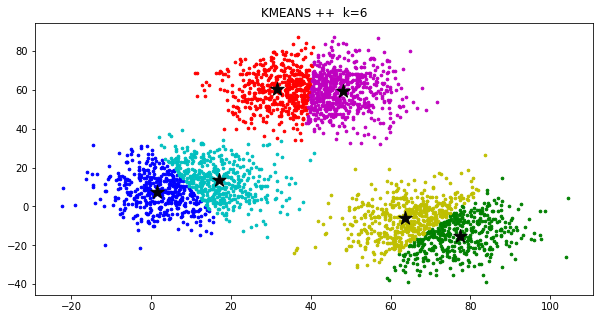

In [811]:
import pandas as pd

data = pd.read_csv('xclara.csv')
f1 = data['V1'].values
f2 = data['V2'].values
X = np.array(list(zip(f1, f2)))

for k in range(2, 7):
    centroids, clusters = kmeans(X, k, 'kmeans++')

    colors = ['r', 'g', 'b', 'y', 'c', 'm']
    fig, ax = plt.subplots(figsize=(10, 5))
    for i in range(k):
        points = np.array([X[j] for j in range(len(X)) if j in clusters[i]])
        ax.scatter(points[:, 0], points[:, 1], s=7, c=colors[i])
    ax.scatter(centroids[:, 0], centroids[:, 1],marker='*', s=200, c='#050505')
    plt.title('KMEANS ++  k='+str(k))

Similarly you can see the results for testing in 3D space.

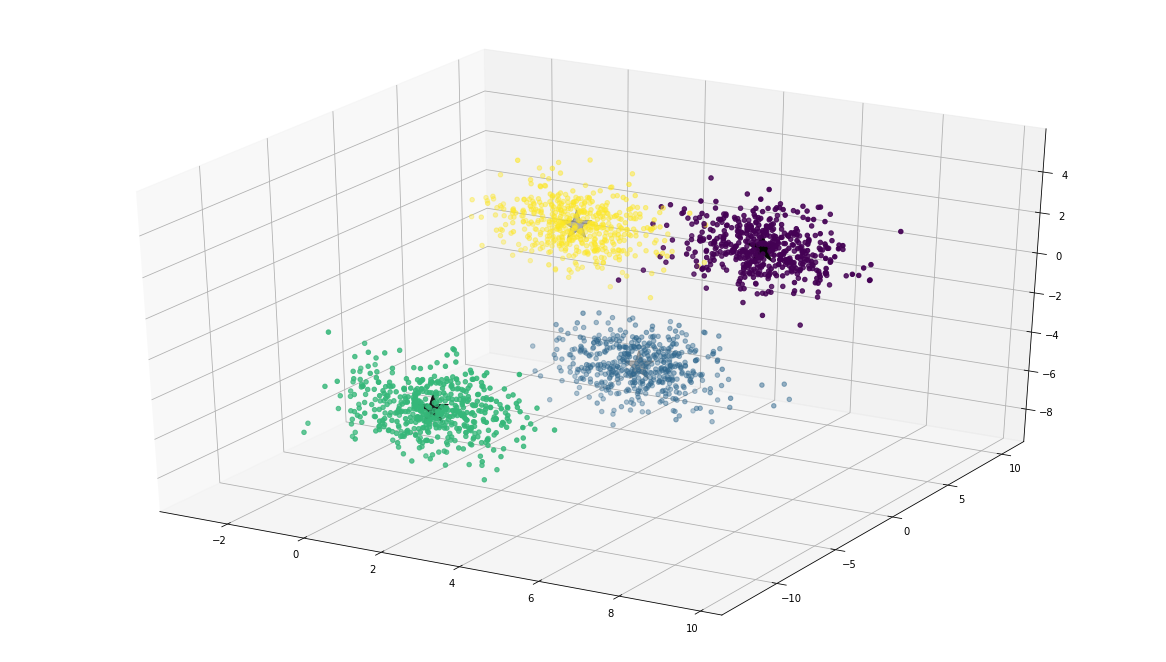

In [827]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.datasets import make_blobs

plt.rcParams['figure.figsize'] = (16, 9)

# Creating a sample dataset with 4 clusters
X, y = make_blobs(n_samples=2000, n_features=3, centers=4)
k = 4
centroids, clusters = kmeans(X, k, 'kmeans++')
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=y)
ax.scatter(centroids[:, 0], centroids[:, 1], centroids[:, 2], marker='*', c='#050505', s=1000)
plt.show()

Something about multiclass prediction using kmeans clustering bothers me. Maybe not so much the idea and math behind it, but the part "find the most common prediction in each cluster and then assume that is the prediction, flipping each element in that cluster to the appropriate label". I think I am just computationally bothered moreso than the logic behind this implementation. Nonetheless, I get the same results as in the instructions. 

In [813]:
from sklearn.datasets import load_breast_cancer
from sklearn.metrics import accuracy_score


def get_accuracy(y, clusters):
    y_pred = np.zeros(y.shape)
    y_pred[clusters[0]] = 1
    acc = accuracy_score(y, y_pred)
    print('Clustering Accuracy:', acc)


cancer = load_breast_cancer()
X = cancer.data
y = cancer.target

k = 2
centroids, clusters = kmeans(X, k, 'kmeans++', tolerance=0.1)
get_accuracy(y, clusters)

Clustering Accuracy: 0.8541300527240774


I only needed to write a single convert_color function to transform original RGB matrix into its clustered version, Using the same CDIST() trick to speed up efficiency. I noticed that different image packages handle images differently and that also effect runtime. Needless to say, image compression is way faster with the matrix implementation of kmeans.

In [828]:
def load_image(image):
    img = Image.open(image)
    # img.load()
    # img.show()
    rgb_img = img.convert('RGB')
    data = np.asarray(rgb_img)
    return data


def convert_color(X, centroids):
    dist = cdist(X, centroids, 'euclidean')
    min_index = dist.argmin(axis=1)
    for i in range(X.shape[0]):
        X[i] = centroids[min_index[i]]

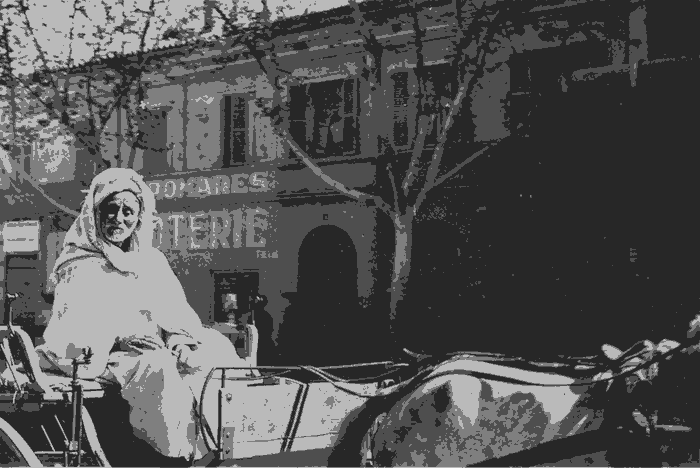

In [834]:
X = load_image('north-africa-1940s-grey.png')
X_ = np.float32(X.reshape((-1, 3)))


k = 4
centroids, clusters = kmeans(X_, k=k, type_centroids='kmeans++', tolerance=.01)
convert_color(X_, centroids)
X_ = np.reshape(X_, (X.shape)).astype(np.uint8)
img_ = Image.fromarray(X_)
display(img_)

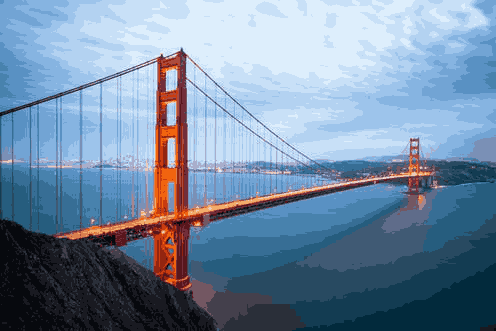

In [830]:
X = load_image('GGB.jpg')
X_ = np.float32(X.reshape((-1, 3)))

k = 32
centroids, clusters = kmeans(X_, k=k, type_centroids='kmeans++', tolerance=.01)
convert_color(X_, centroids)
X_ = np.reshape(X_, (X.shape)).astype(np.uint8)
img_ = Image.fromarray(X_)
display(img_)

It would seem I avoided Terrences' demon form!

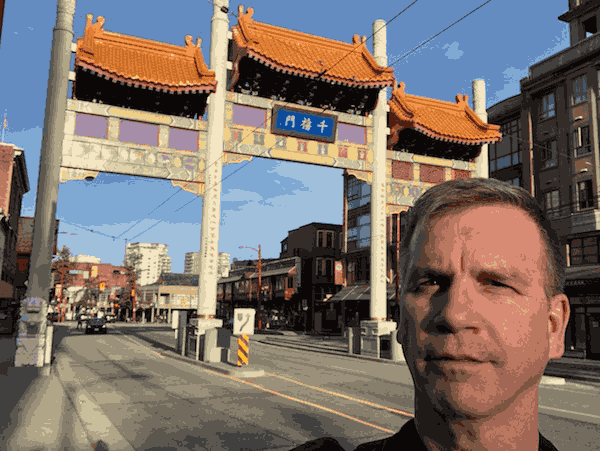

In [832]:
X = load_image('parrt-vancouver.jpg')
X_ = np.float32(X.reshape((-1, 3)))

k = 32
centroids, clusters = kmeans(X_, k=k, type_centroids='kmeans++', tolerance=.01)
convert_color(X_, centroids)
X_ = np.reshape(X_, (X.shape)).astype(np.uint8)
img_ = Image.fromarray(X_)
display(img_)